<h2 id="t1" style="margin-bottom: 18px">Imbalanced datasets</h2>


Class 0: 166469
Class 1: 6365
Proportion of class 0 is  96.32 %


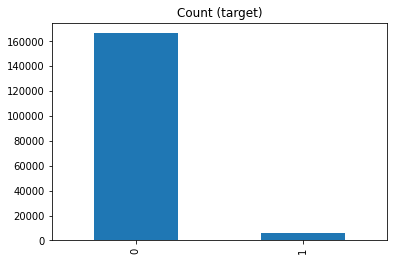

In [ ]:
import numpy as np
import pandas as pd

df_train = pd.read_csv('train.csv')
df_train

target_count = df_train.target.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion of class 0 is ', round(target_count[0] * 100 / (target_count[1] + target_count[0]), 2),'%')

target_count.plot(kind='bar', title='Count (target)');

In [ ]:
df_train

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9.0,1.0,5.0,8.0,0.0,1.0,1.0,0.0,0.0,1.0
1,9,0,1,1,7,0,0,0,0,1,...,3.0,1.0,1.0,9.0,0.0,1.0,1.0,0.0,1.0,0.0
2,13,0,5,4,9,1,0,0,0,1,...,4.0,2.0,7.0,7.0,0.0,1.0,1.0,0.0,1.0,0.0
3,16,0,0,1,2,0,0,1,0,0,...,2.0,2.0,4.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17,0,0,2,0,1,0,1,0,0,...,3.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172829,431930,0,1,1,2,0,0,1,0,0,...,4.0,2.0,2.0,8.0,1.0,1.0,1.0,0.0,0.0,0.0
172830,431933,0,0,1,1,0,0,0,1,0,...,5.0,0.0,1.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0
172831,431936,0,0,1,7,1,6,0,1,0,...,5.0,1.0,1.0,10.0,0.0,1.0,1.0,1.0,1.0,0.0
172832,431938,0,1,1,2,1,0,1,0,0,...,3.0,4.0,1.0,11.0,0.0,1.0,1.0,0.0,1.0,0.0


<h2 id="t2" style="margin-bottom: 18px">The metric trap</h2>

# Applying our best traditional ML model (XGBoost)

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Remove 'id' and 'target' columns
labels = df_train.columns[2:]
df_train = df_train.dropna()

X = df_train[labels]
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.29%


Now let's run the same code, but using only one feature (which should drastically reduce the accuracy of the classifier):

In [ ]:
model = XGBClassifier()
model.fit(X_train[['ps_ind_04_cat']], y_train)
y_pred = model.predict(X_test[['ps_ind_04_cat']])

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.29%


* with all the features - accuracy 96%
* with only 1 feature - accuracy 96%
* this means that Accuracy is a Bad-metric

<h2 id="t3" style="margin-bottom: 18px">Confusion matrix</h2>


Confusion matrix:
 [[33285     0]
 [ 1282     0]]


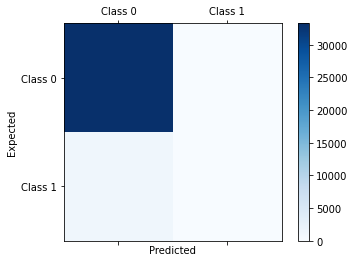

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

* confusion matrix shows that model(XGB) always predicts class-0 only
* so traditional ML model fails in imbalanced dataset

In [ ]:
# solution for bad metric:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, model.predict_proba(X_test[['ps_ind_04_cat']])[:, 1])

0.5097101522636841

  * AUROC of 0.5 means baseline score (poor model)

# Sampling Weights (ignore this section)

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0)
clf.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(random_state=0)

In [ ]:
print("Accuracy : ", clf.score(X_test,y_test) * 100, "%")

Accuracy :  96.22043081802563 %


In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score
confusion_matrix(y_test, clf.predict(X_test))
roc_auc_score(y_test, clf.decision_function(X_test))

0.6056593530841574

In [ ]:
clf = LogisticRegression(class_weight = {0:5,1:95})
clf.fit(X_train,y_train)
print("Accuracy : ", clf.score(X_test,y_test) * 100, "%")
confusion_matrix(y_test, clf.predict(X_test))
roc_auc_score(y_test, clf.decision_function(X_test))

Accuracy :  81.73648737941059 %


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.6146244757699229

<h2 id="t4" style="margin-bottom: 18px">Resampling</h2>


![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/resampling.png)

In [ ]:
# Class count
count_class_0, count_class_1 = df_train.target.value_counts()

# Divide by class
df_class_0 = df_train[df_train['target'] == 0]
df_class_1 = df_train[df_train['target'] == 1]

count_class_0, count_class_1


(109331, 4173)

<h2 id="t5">Random under-sampling</h2>

In [ ]:
count_class_1, count_class_0

(3388, 88544)

Random under-sampling:
0    4173
1    4173
Name: target, dtype: int64


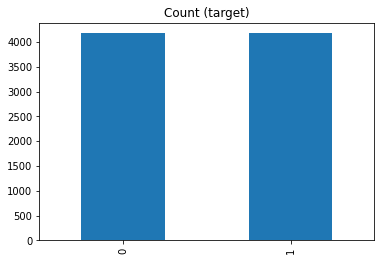

In [ ]:
df_class_0_under = df_class_0.sample(count_class_1) #it will randomly sample count_class_1 number of rows from the dataframe
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.target.value_counts())

df_test_under.target.value_counts().plot(kind='bar', title='Count (target)');

<h2 id="t6">Random over-sampling</h2>

Random over-sampling:
0    109331
1    109331
Name: target, dtype: int64


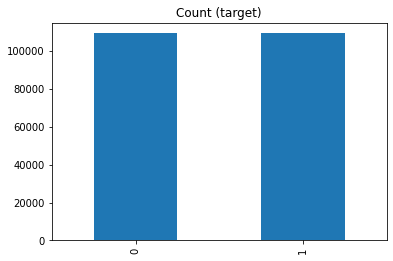

In [ ]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.target.value_counts())

df_test_over.target.value_counts().plot(kind='bar', title='Count (target)');

# <h2 id="t7" style="margin-bottom: 18px">Python imbalanced-learn module</h2>

A number of more sophisticated resapling techniques have been proposed in the scientific literature.

For example, we can cluster the records of the majority class, and do the under-sampling by removing records from each cluster, thus seeking to preserve information. In over-sampling, instead of creating exact copies of the minority class records, we can introduce small variations into those copies, creating more diverse synthetic samples.

Let's apply some of these resampling techniques, using the Python library [imbalanced-learn](http://contrib.scikit-learn.org/imbalanced-learn/stable/). It is compatible with scikit-learn and is part of scikit-learn-contrib projects.

In [ ]:
import imblearn     # creating our own imbalanced dataset

For ease of visualization, let's create a small unbalanced sample dataset using the <code>make_classification</code> method:

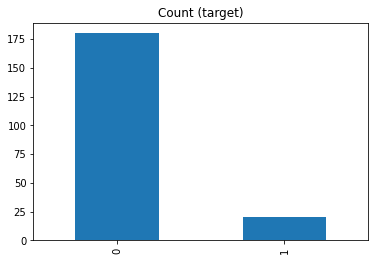

In [ ]:
from sklearn.datasets import make_classification #subpackage used for creating own classifcation dataset
import pandas as pd

X, y = make_classification(
    n_classes=2, class_sep=0.75, weights=[0.9, 0.1],
    n_informative=2, n_redundant=0, flip_y=0,
    n_features=2, n_clusters_per_class=2,
    n_samples=200, random_state=10
)

df = pd.DataFrame(X)
df['target'] = y
#df
df.target.value_counts().plot(kind='bar', title='Count (target)');

We will also create a 2-dimensional plot function, <code>plot_2d_space</code>, to see the data distribution:

In [ ]:
# function for plotting
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

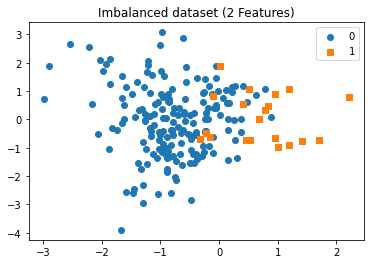

In [ ]:
# plotting
import matplotlib.pyplot as plt
import numpy as np

plot_2d_space(X, y, 'Imbalanced dataset (2 Features)')

<h2 id="#t72">Random under-sampling and over-sampling with imbalanced-learn</h2>

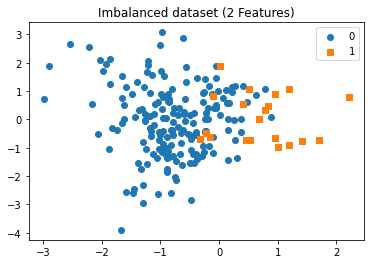

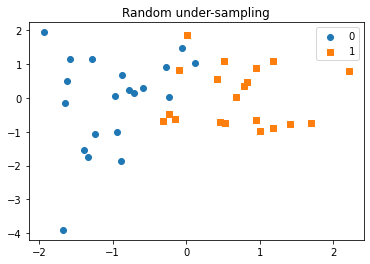

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler() #Intialise the model
X_rus, y_rus = rus.fit_resample(X, y) #resampling the data 

#print('Removed indexes:', id_rus)

plot_2d_space(X, y, 'Imbalanced dataset (2 Features)')
plot_2d_space(X_rus, y_rus, 'Random under-sampling')

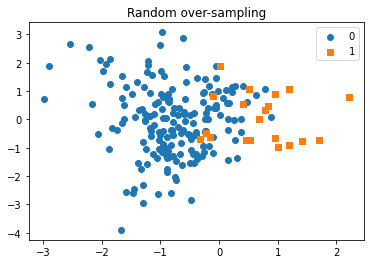

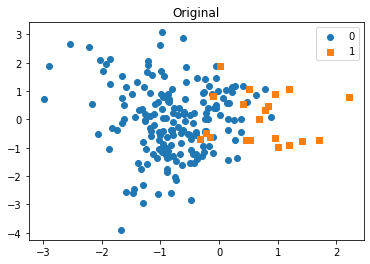

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler() #Initialis the model 
X_ros, y_ros = ros.fit_resample(X, y) #Fit the model

#print(X_ros.shape[0] - X.shape[0], 'new random picked points')

plot_2d_space(X_ros, y_ros, 'Random over-sampling')
plot_2d_space(X, y, 'Original')

* since the datapoints are duplicated, they overlap. So the graph looks similar

In [ ]:
y_ros.sum(), y.sum(), y_rus.sum()

(180, 20, 20)

<h2 id="t8" style="margin-bottom: 18px">Under-sampling: Tomek links</h2>

Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/tomek.png?v=2)

In the code below, we'll use <code>ratio='majority'</code> to resample the majority class.

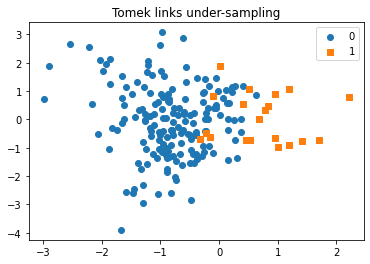

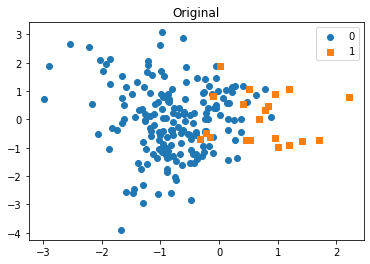

In [ ]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(sampling_strategy='majority')  # delete the majority datapoint
X_tl, y_tl = tl.fit_resample(X, y)

#print('Removed indexes:', id_tl)

plot_2d_space(X_tl, y_tl, 'Tomek links under-sampling')
plot_2d_space(X, y, 'Original')

* still there is no clear boundary
* thats why we never use tomek links alone. 
* we use tomek links + cluster centroids

In [ ]:
y_tl.sum()/y_tl.shape[0], y.sum()/y.shape[0]

(0.10362694300518134, 0.1)

* 10% to 10.3%
* very slight improvement only

<h2 id="t9" style="margin-bottom: 18px">Under-sampling: Cluster Centroids</h2>

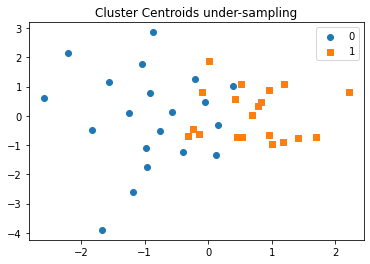

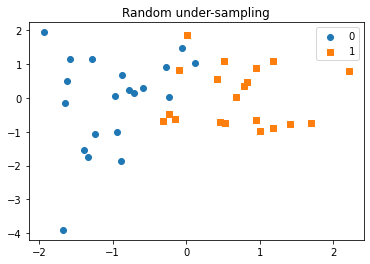

In [ ]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(sampling_strategy={0: 20})    # in class-0, take 20 datapoints only
X_cc, y_cc = cc.fit_resample(X, y)

plot_2d_space(X_cc, y_cc, 'Cluster Centroids under-sampling')
#plot_2d_space(X, y, 'Original')
plot_2d_space(X_rus, y_rus, 'Random under-sampling')

In [ ]:
y_cc.sum()/y_cc.shape[0]
#y_cc

<h2 id="t10" style="margin-bottom: 18px">Over-sampling: SMOTE</h2>

SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picingk a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

 ![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/smote.png)

We'll use <code>ratio='minority'</code> to resample the minority class.

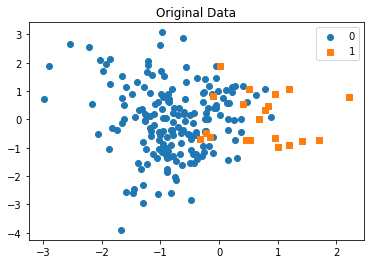

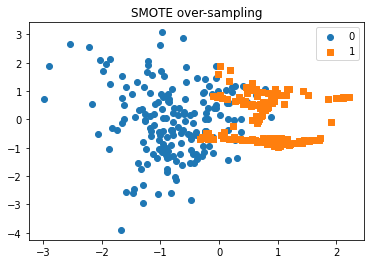

In [ ]:
from imblearn.over_sampling import SMOTE

plot_2d_space(X, y, 'Original Data')

smote = SMOTE(sampling_strategy='minority')   # increase my minority class
X_sm, y_sm = smote.fit_resample(X, y)

plot_2d_space(X_sm, y_sm, 'SMOTE over-sampling')

SOLUTION : 
<h2 id="t11" style="margin-bottom: 18px">Over-sampling followed by under-sampling</h2>

Now, we will do a combination of over-sampling and under-sampling, using the SMOTE and Tomek links techniques:

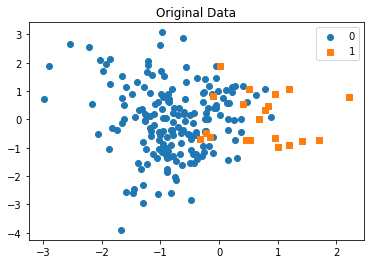

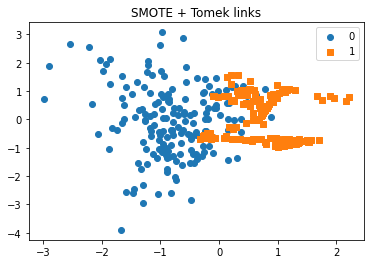

In [ ]:
from imblearn.combine import SMOTETomek    # oversample + undersample

plot_2d_space(X, y, 'Original Data')

smt = SMOTETomek(sampling_strategy='all')
X_smt, y_smt = smt.fit_resample(X, y)

plot_2d_space(X_smt, y_smt, 'SMOTE + Tomek links')

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

lr = LogisticRegression()
lr.fit(X,y)
lr.score(X,y)

print( "AUROC on original dataset : ", roc_auc_score(y, lr.predict_proba(X)[:, 1]))

lr = LogisticRegression()
lr.fit(X_smt,y_smt)
lr.score(X_smt,y_smt)

print( "AUROC on the sampled dataset : ",roc_auc_score(y, lr.predict_proba(X)[:, 1]))

AUROC on original dataset :  0.9513888888888888
AUROM on the sampled dataset :  0.9508333333333333


* in this case, there is no big difference in the auroc score